In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%matplotlib notebook




In [4]:
import numpy
import scipy
import scipy.optimize
import math
import random
import os
import sys
#
import matplotlib
import pylab as plt
import matplotlib.dates as mpd
#
import libcomcat as comcat
#
#import libcomcat.utils
#from libcomcat.utils import get_phase_dataframe, get_summary_data_frame
#from libcomcat.utils import get_summary_data_frame
from libcomcat.search import search,count,get_event_by_id
from datetime import datetime
import os.path
import pandas as pd

In [5]:
eventlist = search(starttime=datetime(1990,1,17,12,30),
                       endtime=datetime(2017,1,18,12,35),
                       minmagnitude=3.0,
                      minlatitude=31., maxlatitude=42.,
                      minlongitude=-125., maxlongitude=-115)
#

catlen:  15194


Text(0,0.5,'Interval $\\Delta t$')

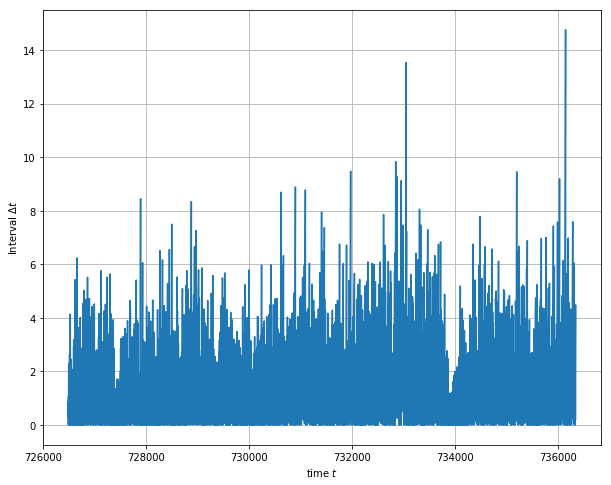

In [6]:
#
catalog = [[ev.time, ev.latitude, ev.longitude, ev.magnitude, ev.depth, mpd.date2num(ev.time)] for ev in eventlist]
#
catalog = numpy.core.records.fromarrays(zip(*catalog), dtype=[('event_date', 'M8[us]'), 
          ('lat','f8'), ('lon','f8'), ('mag','f8'), ('depth','f8'), ('event_date_float', 'f8')])
print('catlen: ', len(eventlist))
#
fg = plt.figure(figsize=(10,8))
ax1 = plt.gca()
ax1.grid()
#
ax1.plot(catalog['event_date_float'][1:], numpy.diff(catalog['event_date_float']), ls='-', marker='')
#
ax1.set_xlabel('time $t$')
ax1.set_ylabel('Interval $\Delta t$')
#ax1.set_yscale('log')

In [7]:
# now, we'll want to compute running entropy. instead of binning, let's use cumulative probabilities -- which
#  makes sense for earthquake intervals (from a physical perspective).
#
def entropy(X, invert=False):
    # entropy of the sequence X
    #
    # TODO: so it would be nice to use cumulative probabilities, not pdf "likelihood", since it (nominally) avoids
    #  the problem of bias-by-binning. on the other hand, the probabilities area always the same (P_k = k/N).
    #  so we could get around that by interpolating, say to N' = 10*N, or something like that. that would extract
    #  the shape of the distribution. generally, it looks like there is always some sort of subjective bias in
    #  entropy...
    #  The equivalent of this is width-weighted aggretation, so P = (P_k * \Delta x)/\Delta X . Note this is 
    #   equivalent to interpolating a bunch of points between (x_1, x_2). 
    #Ps = T
    pass

SyntaxError: invalid syntax (<ipython-input-7-35fa0235729b>, line 7)